In [162]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle as pickle

ModuleNotFoundError: No module named 'seaborn'

In [142]:
with open('frames_temp.dat', 'rb') as f:
    frames,ts = pickle.load(f)

In [148]:
def image_processing(eye_frame, threshold):
    """Performs operations on the eye frame to isolate the iris

    Arguments:
        eye_frame (numpy.ndarray): Frame containing an eye and nothing else
        threshold (int): Threshold value used to binarize the eye frame

    Returns:
        A frame with a single element representing the iris
    """
    kernel = np.ones((3, 3), np.uint8)
    f_frame = cv2.bilateralFilter(eye_frame, 10, 15, 15)
    # new_frame = cv2.erode(new_frame, kernel, iterations=3)
    new_frame = cv2.threshold(f_frame, threshold, 255, cv2.THRESH_BINARY)[1]
    new_frame = cv2.morphologyEx(new_frame, cv2.MORPH_OPEN, kernel)
    new_frame = cv2.morphologyEx(new_frame, cv2.MORPH_CLOSE, kernel)

    return new_frame, f_frame

def detect_pupil(eye_frame, threshold):
    """Detects the iris and estimates the position of the iris by
    calculating the centroid.

    Arguments:
        eye_frame (numpy.ndarray): Frame containing an eye and nothing else
    """
    thr_frame, iris_frame = image_processing(eye_frame, threshold)
    contours, _ = cv2.findContours(thr_frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[-2:]
    contours = sorted(contours, key=cv2.contourArea)
    return iris_frame, thr_frame, contours

PLOT = 0
pupil_size = np.array([])
for frame in frames[:]:
    print(1)
    thr = np.percentile(frame[frame<255],10)
    f, n, c = detect_pupil(frame,thr)
    pupil_size = np.hstack((pupil_size, np.sum(n==0)))
    if PLOT:
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plt.imshow(frame, cmap='gray')
        xc = [t[0][0] for t in c[0]]
        yc = [t[0][1] for t in c[0]]
        plt.plot(xc,yc,'r')
        plt.subplot(1,2,2)
        # plt.imshow(f); plt.colorbar()
        plt.hist(f[f<255])
        plt.vlines(thr, 0, 100, color='r')

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [153]:
pupil_size[0]

33.0

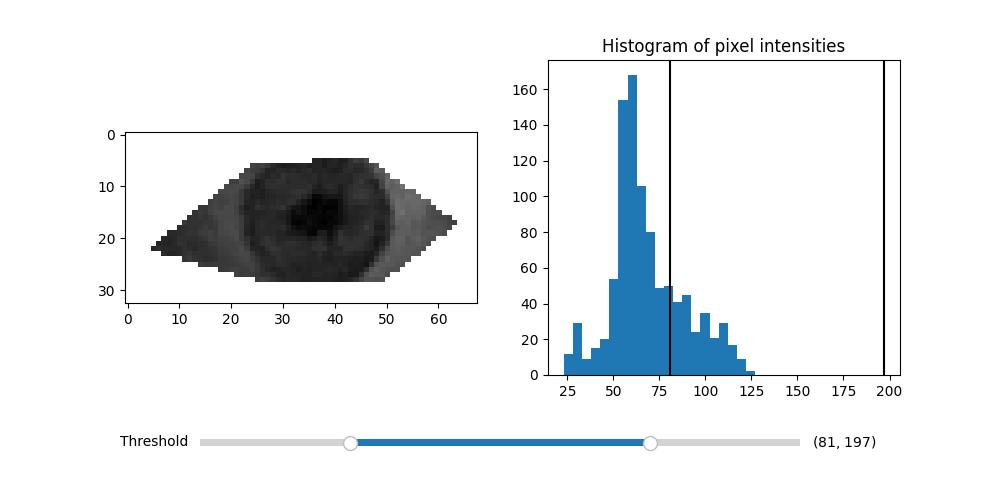

In [145]:
%matplotlib widget
from matplotlib.widgets import RangeSlider

img = frames[10]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(bottom=0.25)

im = axs[0].imshow(img, cmap='gray')
axs[1].hist(img[img<255], bins='auto')
axs[1].set_title('Histogram of pixel intensities')

# Create the RangeSlider
slider_ax = fig.add_axes([0.20, 0.1, 0.60, 0.03])
slider = RangeSlider(slider_ax, "Threshold", img.min(), img.max())

# Create the Vertical lines on the histogram
lower_limit_line = axs[1].axvline(slider.val[0], color='k')
upper_limit_line = axs[1].axvline(slider.val[1], color='k')


def update(val):
    # The val passed to a callback by the RangeSlider will
    # be a tuple of (min, max)

    # Update the image's colormap
    im.norm.vmin = val[0]
    im.norm.vmax = val[1]

    # Update the position of the vertical lines
    lower_limit_line.set_xdata([val[0], val[0]])
    upper_limit_line.set_xdata([val[1], val[1]])

    # Redraw the figure to ensure it updates
    fig.canvas.draw_idle()

slider.on_changed(update)
plt.show()

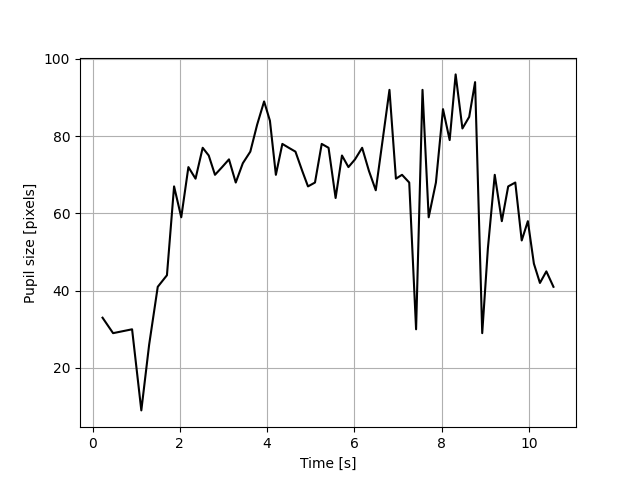

In [163]:
plt.figure()
plt.plot(ts, pupil_size, 'k')
plt.ylabel('Pupil size [pixels]')
plt.xlabel('Time [s]')
plt.grid('on')

In [165]:
### create video to show pupil detection
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

# find max frame size
maxx = np.max([f.shape[0] for f in frames])
maxy = np.max([f.shape[1] for f in frames])
# convert list to tensor of frames
frames_ = np.ones((len(frames),maxx,maxy),dtype='uint8') * 255
for i in range(len(frames)):
    frames_[i, :frames[i].shape[0],  :frames[i].shape[1]] = frames[i]
i = 0
def updatefig(i):
    global frames_
    # update frame - find offsets
    frame = frames_[i]
    # find contour
    thr = np.percentile(frame[frame<255], 10)
    f, n, c = detect_pupil(frame,thr)
    im.set_array(frame)
    xc = [t[0][0] for t in c[0]]
    yc = [t[0][1] for t in c[0]]
    cont.set_data(xc,yc)
    ps.set_text(f'pupil size = {np.sum(n==0)}')
    ts_.set_text('Time = %.3f'%ts[i])
    return im,

fig = plt.figure(figsize=(5,5))
im = plt.imshow(frames_[i], cmap='Greys_r')
cont, = plt.plot([],[],'r')
ps = plt.text(maxy-15, 3, [], color='r')
ts_ = plt.text(maxy-15, 6, [], color='k')
plt.axis('off')
plt.close()

ani = animation.FuncAnimation(fig, updatefig, frames=len(frames), interval=250, blit=True,
                                repeat=True, repeat_delay=1000)
ani.save('pupil_detection.mp4')
HTML(ani.to_jshtml())